# 1. Setup and Load Data

## 1.1 Install Dependencies and Setup

In [20]:
# Don't have to do this step as your "tensorflow" env has all tools installed
#!pip install tensorflow opencv-python matplotlib

In [21]:
#!pip list

In [22]:
import tensorflow as tf
import os

In [23]:
gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [24]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [25]:
cpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## 1.2 Remove Doggy Images

In [26]:
import cv2
import imghdr
from matplotlib import pyplot as plt

In [27]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']
data_dir = '/Users/abbazs/Projects/ML-Data-Science/Image Classification /images'

/Users/abbazs/Projects/ML-Data-Science/Image Classification /images/happy/smiling-faces.jpg


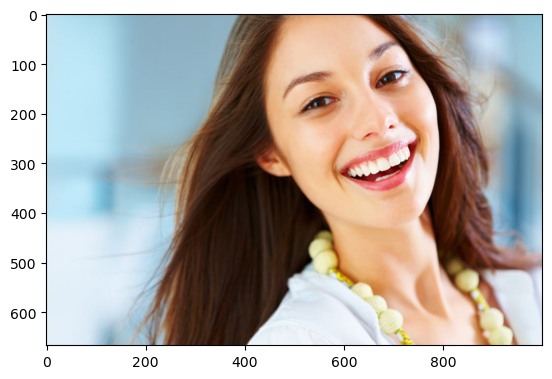

In [28]:
sample_img_name = os.listdir(os.path.join(data_dir, "happy"))[0]
sample_img_path = os.path.join(data_dir,"happy", sample_img_name)
print(sample_img_path)
# Image comes in BGR format
img_bgr = cv2.imread(sample_img_path)

# Convert image to RGB
img_rgb = plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
img_rgb

In [29]:
for image_folder in os.listdir(data_dir):
  if image_folder == ".DS_Store":
      continue
  for image in os.listdir(os.path.join(data_dir,image_folder)):
    image_path = os.path.join(data_dir,image_folder,image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print("Image not in ext list {}".format(image_path))
        os.remove(image_path)
    except Exception as e:
      print("Issue with image {}".format(image_path))

## 1.3 Load Data

In [30]:
import numpy as np
from matplotlib import pyplot as plt

In [31]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 453 files belonging to 2 classes.


In [32]:
data_iterator = data.as_numpy_iterator()

In [33]:
#Re-run to get next batch of data
batch = data_iterator.next()

In [34]:
#Class 1 is sad
#Class 0 is happy
batch[0].shape

(32, 256, 256, 3)

In [35]:
batch[1]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0], dtype=int32)

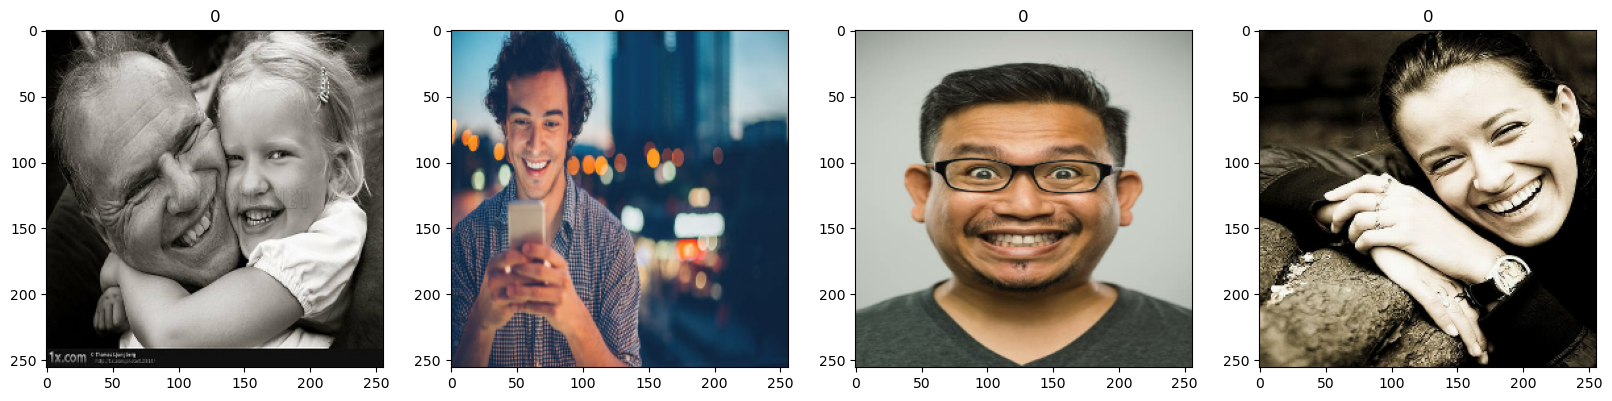

In [36]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])